# Exploratory Data Analysis (EDA)

Let's dig into the data and explore it.


In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !rm -rf dreamix
    !rm -rf sample_data
    !git clone https://github.com/chemcognition-lab/dreamix.git
    %cd dreamix
    sys.path.append('/content/dreamix/src')
    fname = f''
else:
    print('Not in colab, assuming your have your kernel setup')
    sys.path.append("../src")
    fname = f'../'

Cloning into 'dreamix'...
remote: Enumerating objects: 1780, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 1780 (delta 13), reused 16 (delta 10), pack-reused 1681
Receiving objects: 100% (1780/1780), 139.88 MiB | 23.10 MiB/s, done.
Resolving deltas: 100% (833/833), done.
Updating files: 100% (458/458), done.
/content/dreamix


## Imports


In [ ]:
import pandas as pd
import rdkit.Chem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdchem
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator
from dataloader.representations.features import (
    parse_status,
)  # , rdkit2d_normalized_features
from rdkit.Chem.Descriptors import ExactMolWt
import umap

import numpy as np
from sklearn.decomposition import PCA

import matplotlib as mpl
from collections import Counter

mpl.rcParams["figure.facecolor"] = "white"

Utility functions


In [ ]:
def get_elements(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        elements = {atom.GetSymbol() for atom in mol.GetAtoms()}
        return tuple(sorted(elements))
    else:
        return []


def is_chiral(mol):
    chiral_centers = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
    return len(chiral_centers) > 0


def check_cis_trans_isomerism(mol):
    has_cis_trans = False
    for bond in mol.GetBonds():
        # Check if the bond is a double bond
        if bond.GetBondType() == rdchem.BondType.DOUBLE:
            # Check if the double bond has stereochemistry information
            stereo = bond.GetStereo()
            if stereo in [
                rdchem.BondStereo.STEREOZ,
                rdchem.BondStereo.STEREOE,
                rdchem.BondStereo.STEREOCIS,
                rdchem.BondStereo.STEREOTRANS,
            ]:
                has_cis_trans = True
                break

    return has_cis_trans


def rdkit2d_normalized_features(smiles):
    generator = MakeGenerator((f"rdkit2dhistogramnormalized",))
    fps = parse_status(generator, smiles)
    return fps


def get_pna(df):
    df_rdkit2d_norm = pd.DataFrame(
        columns=["Dataset", "Mixture Label"]
        + [f"rdkit2d_norm_{i}" for i in range(43)]
        + ["min", "max", "mean", "std"]
    )

    for i in range(len(df)):
        df_rdkit2d_norm.loc[i, "Dataset"] = df.loc[i, "Dataset"]
        df_rdkit2d_norm.loc[i, "Mixture Label"] = df.loc[i, "Mixture Label"]
        for j in range(len(df.columns) - 2):
            if not pd.isnull(df[f"smi_{j}"][i]):
                df_rdkit2d_norm.loc[i, f"rdkit2d_norm_{j}"] = (
                    rdkit2d_normalized_features(df[f"smi_{j}"][i])
                )
            else:
                df_rdkit2d_norm.loc[i, f"rdkit2d_norm_{j}"] = None

    assert len(df_rdkit2d_norm) == len(df)

    df_rdkit2d_norm["min"] = None
    df_rdkit2d_norm["max"] = None
    df_rdkit2d_norm["avg"] = None
    df_rdkit2d_norm["std"] = None

    # Set dtype to object to hold arrays
    df_rdkit2d_norm["min"] = df_rdkit2d_norm["min"].astype(object)
    df_rdkit2d_norm["max"] = df_rdkit2d_norm["max"].astype(object)
    df_rdkit2d_norm["avg"] = df_rdkit2d_norm["avg"].astype(object)
    df_rdkit2d_norm["std"] = df_rdkit2d_norm["std"].astype(object)

    for i in range(len(df_rdkit2d_norm)):
        all_features = []
        for j in range(len(df.columns) - 2):
            if df_rdkit2d_norm[f"rdkit2d_norm_{j}"][i] != None:
                all_features.append(df_rdkit2d_norm[f"rdkit2d_norm_{j}"][i])

        min_features = np.min(all_features, axis=0)
        max_features = np.max(all_features, axis=0)
        avg_features = np.mean(all_features, axis=0)
        std_features = np.std(all_features, axis=0)

        assert (
            len(min_features)
            == len(max_features)
            == len(avg_features)
            == len(std_features)
            == 200
        )

        df_rdkit2d_norm.at[i, "min"] = min_features
        df_rdkit2d_norm.at[i, "max"] = max_features
        df_rdkit2d_norm.at[i, "avg"] = avg_features
        df_rdkit2d_norm.at[i, "std"] = std_features

    df_rdkit2d_norm["PNA"] = None
    df_rdkit2d_norm["PNA"] = df_rdkit2d_norm["PNA"].astype(object)

    for i in range(0, len(df_rdkit2d_norm)):
        min_arr = df_rdkit2d_norm["min"][i]
        max_arr = df_rdkit2d_norm["max"][i]
        avg_arr = df_rdkit2d_norm["avg"][i]
        std_arr = df_rdkit2d_norm["std"][i]

        PNA = np.concatenate((min_arr, max_arr, avg_arr, std_arr), axis=0)
        df_rdkit2d_norm.at[i, "PNA"] = PNA
        assert len(df_rdkit2d_norm["PNA"][i]) == 200 * 4

    return df_rdkit2d_norm

# EDA of Mixture based on SMILES strings


In [ ]:
title = "DREAM Challenge Mixture Dataset"
df = pd.read_csv("datasets/competition_train/mixture_smi_definitions_clean.csv")
df_rdkit2d_norm = get_pna(df)

In [ ]:
umap_model = umap.UMAP(metric="cosine", densmap=True, random_state=42, low_memory=False)
X_umap = umap_model.fit_transform(list(df_rdkit2d_norm["PNA"]))
df_rdkit2d_norm["UMAP_0"], df_rdkit2d_norm["UMAP_1"] = X_umap[:, 0], X_umap[:, 1]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'DREAM Challenge Mixture Dataset Distribution')

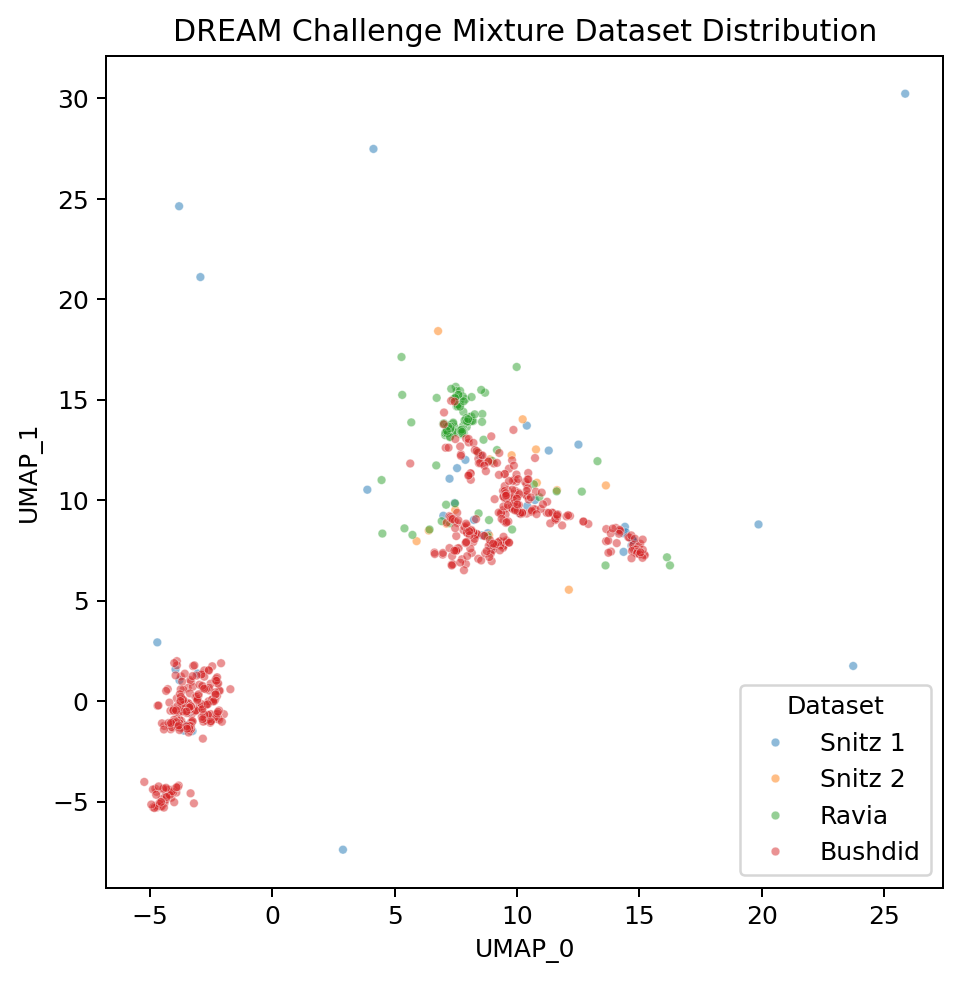

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=180)
# g = sns.scatterplot(x="UMAP_0", y="UMAP_1", data=df, ax=ax, hue=df['Intensity1'], s=12, alpha=0.8, palette='coolwarm')
g = sns.scatterplot(
    x="UMAP_0", y="UMAP_1", hue="Dataset", data=df_rdkit2d_norm, ax=ax, s=12, alpha=0.5
)
ax.legend(title="Dataset")
ax.set_title(f"{title} Distribution")

[0.26599677 0.11970158]


Text(0, 0.5, 'PC1 (12.0%)')

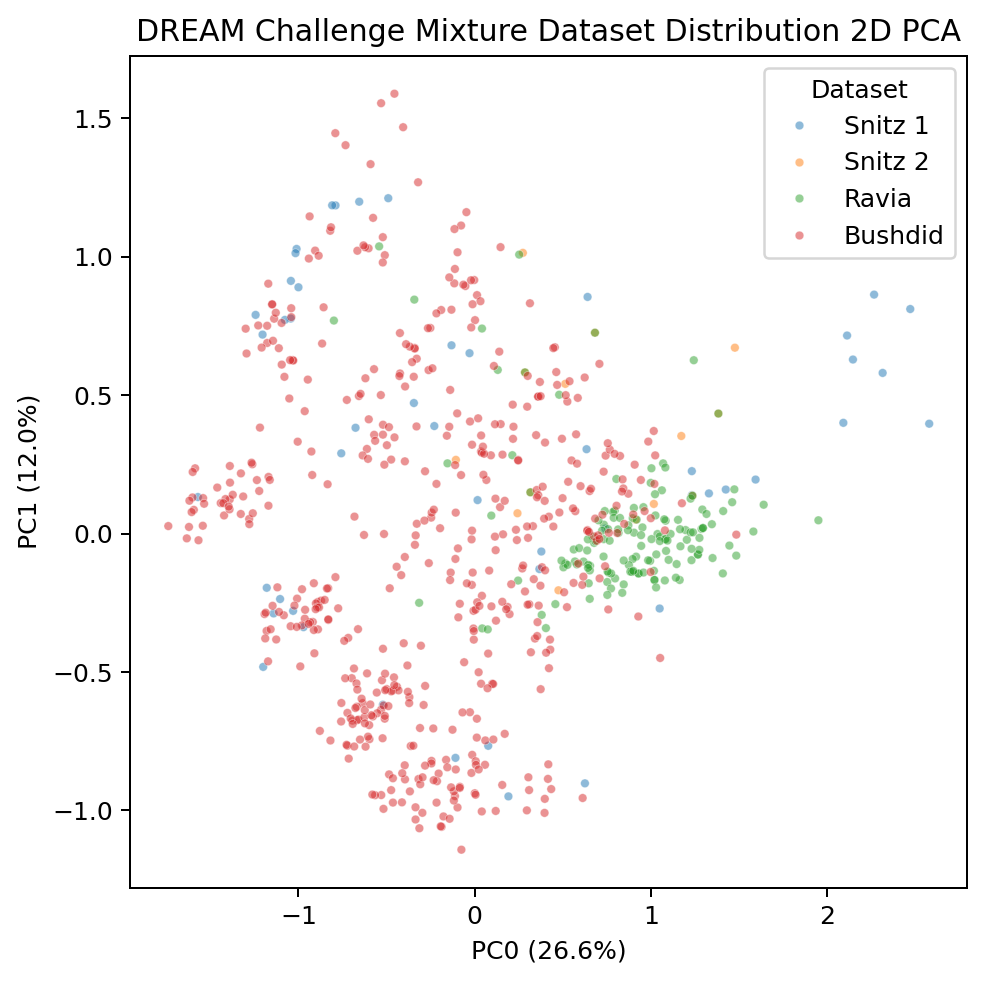

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(list(df_rdkit2d_norm["PNA"]))
print(pca.explained_variance_ratio_)
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=180)
# g = sns.scatterplot(x=principalComponents[:, 0], y=principalComponents[:, 1], ax=ax, hue=df["Intensity1"], s=12, alpha=0.8, palette='coolwarm')
g = sns.scatterplot(
    x=principalComponents[:, 0],
    y=principalComponents[:, 1],
    ax=ax,
    s=12,
    alpha=0.5,
    hue=df_rdkit2d_norm["Dataset"],
)
ax.set_title(f"{title} Distribution 2D PCA")
ax.set_xlabel(f"PC0 ({pca.explained_variance_ratio_[0]*100:.01f}%)")
ax.set_ylabel(f"PC1 ({pca.explained_variance_ratio_[1]*100:.01f}%)")

Text(0.5, 1.0, 'DREAM Challenge Mixture Dataset 2D PC Cumulative')

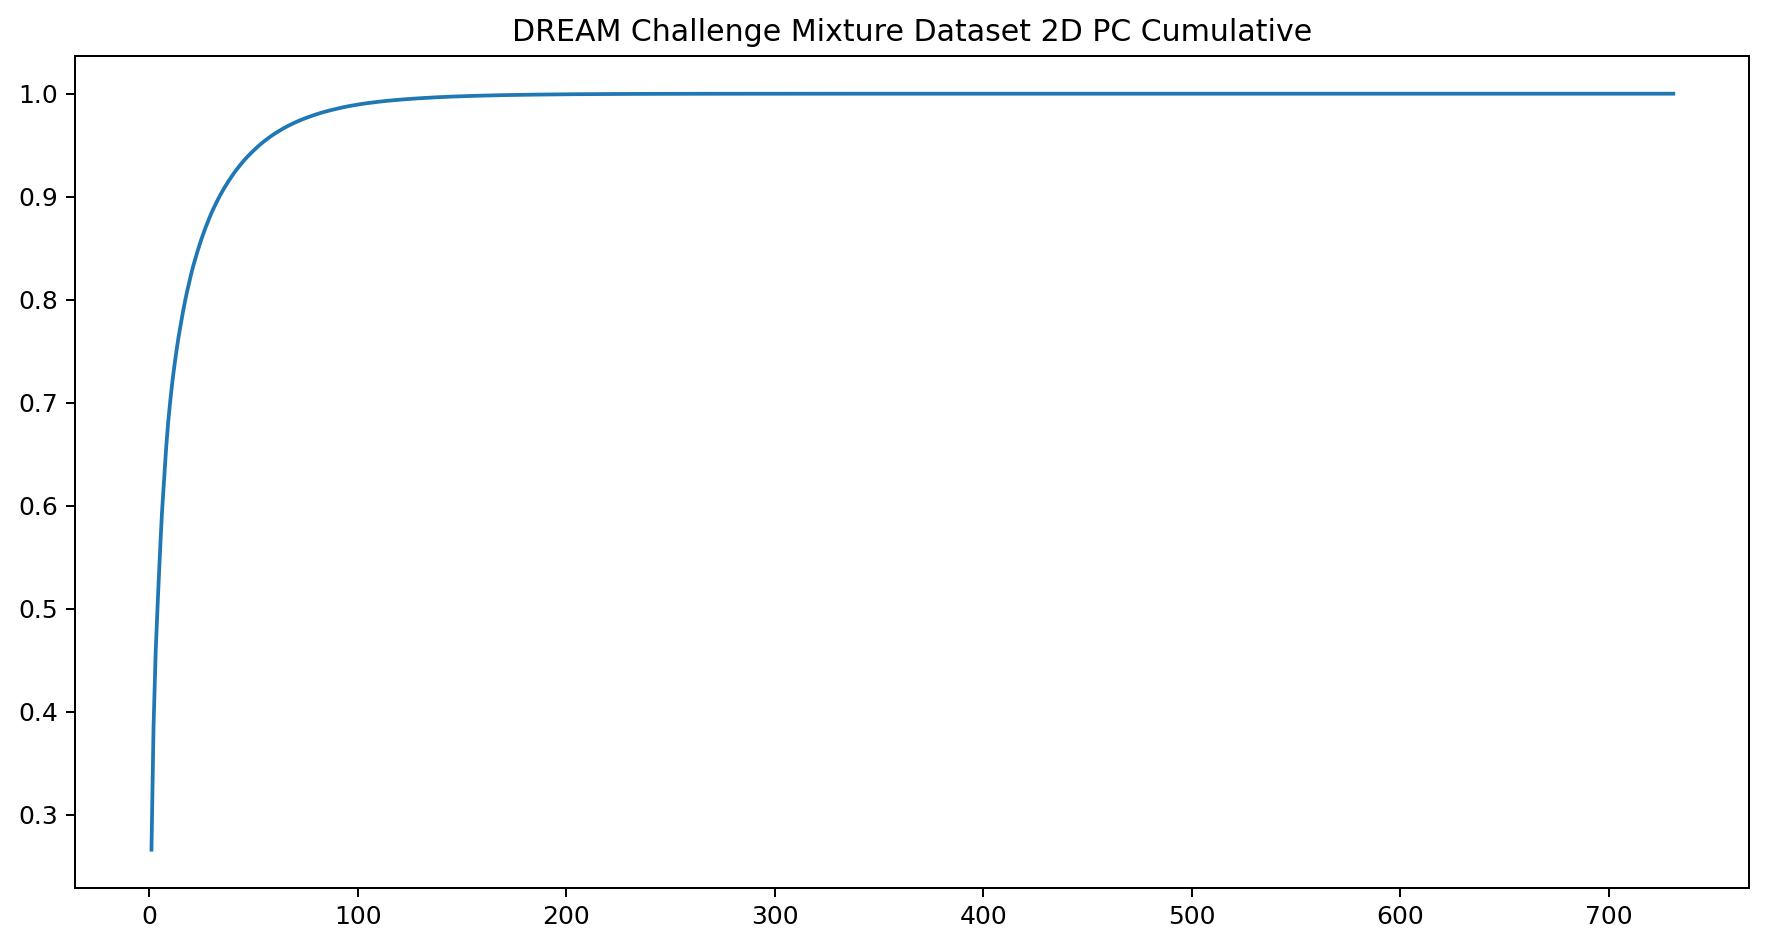

In [ ]:
pca = PCA(n_components=len(df))
principalComponents = pca.fit_transform(list(df_rdkit2d_norm["PNA"]))
cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=180)
g = sns.lineplot(
    x=range(1, len(cumulative_variance_explained) + 1), y=cumulative_variance_explained
)
ax.set_title(f"{title} 2D PC Cumulative")

# EDA of mono-molecule based on SMILES string


In [49]:
df_snitz = pd.read_csv("notebooks/eda_csv/snitz_mono-molecule.csv")
df_ravia45 = pd.read_csv("notebooks/eda_csv/ravia_exp45_mono-molecule.csv")
df_ravia12 = pd.read_csv("notebooks/eda_csv/ravia_exp12_mono-molecule.csv")
df_bushdid = pd.read_csv("notebooks/eda_csv/bushdid_mono-molecule.csv")
df_test = pd.read_csv("notebooks/eda_csv/test_mono-molecule.csv")

df_snitz["IsomericSMILES"] = df_snitz["IsomericSMILES"].astype(str)
df_ravia45["IsomericSMILES"] = df_ravia45["IsomericSMILES"].astype(str)
df_ravia12["IsomericSMILES"] = df_ravia12["IsomericSMILES"].astype(str)
df_bushdid["IsomericSMILES"] = df_bushdid["IsomericSMILES"].astype(str)
df_test["IsomericSMILES"] = df_test["IsomericSMILES"].astype(str)


# Function to safely convert SMILES to RDKit molecule
def safe_mol_from_smiles(smiles):
    try:
        return Chem.MolFromSmiles(smiles)
    except Exception as e:
        print(f"Error processing SMILES: {smiles}, Error: {e}")
        return None


# Apply the conversion to rdkit molecule objects
df_snitz["rdkit"] = df_snitz["IsomericSMILES"].apply(safe_mol_from_smiles)
df_ravia45["rdkit"] = df_ravia45["IsomericSMILES"].apply(safe_mol_from_smiles)
df_ravia12["rdkit"] = df_ravia12["IsomericSMILES"].apply(safe_mol_from_smiles)
df_bushdid["rdkit"] = df_bushdid["IsomericSMILES"].apply(safe_mol_from_smiles)
df_test["rdkit"] = df_test["IsomericSMILES"].apply(safe_mol_from_smiles)


# Function to safely calculate ExactMolWt
def safe_exact_mol_wt(mol):
    if mol is not None:
        return Descriptors.ExactMolWt(mol)
    else:
        return None


# Apply the function to calculate the exact molecular weight
df_snitz["mw"] = df_snitz["rdkit"].apply(safe_exact_mol_wt)
df_ravia45["mw"] = df_ravia45["rdkit"].apply(safe_exact_mol_wt)
df_ravia12["mw"] = df_ravia12["rdkit"].apply(safe_exact_mol_wt)
df_bushdid["mw"] = df_bushdid["rdkit"].apply(safe_exact_mol_wt)
df_test["mw"] = df_test["rdkit"].apply(safe_exact_mol_wt)

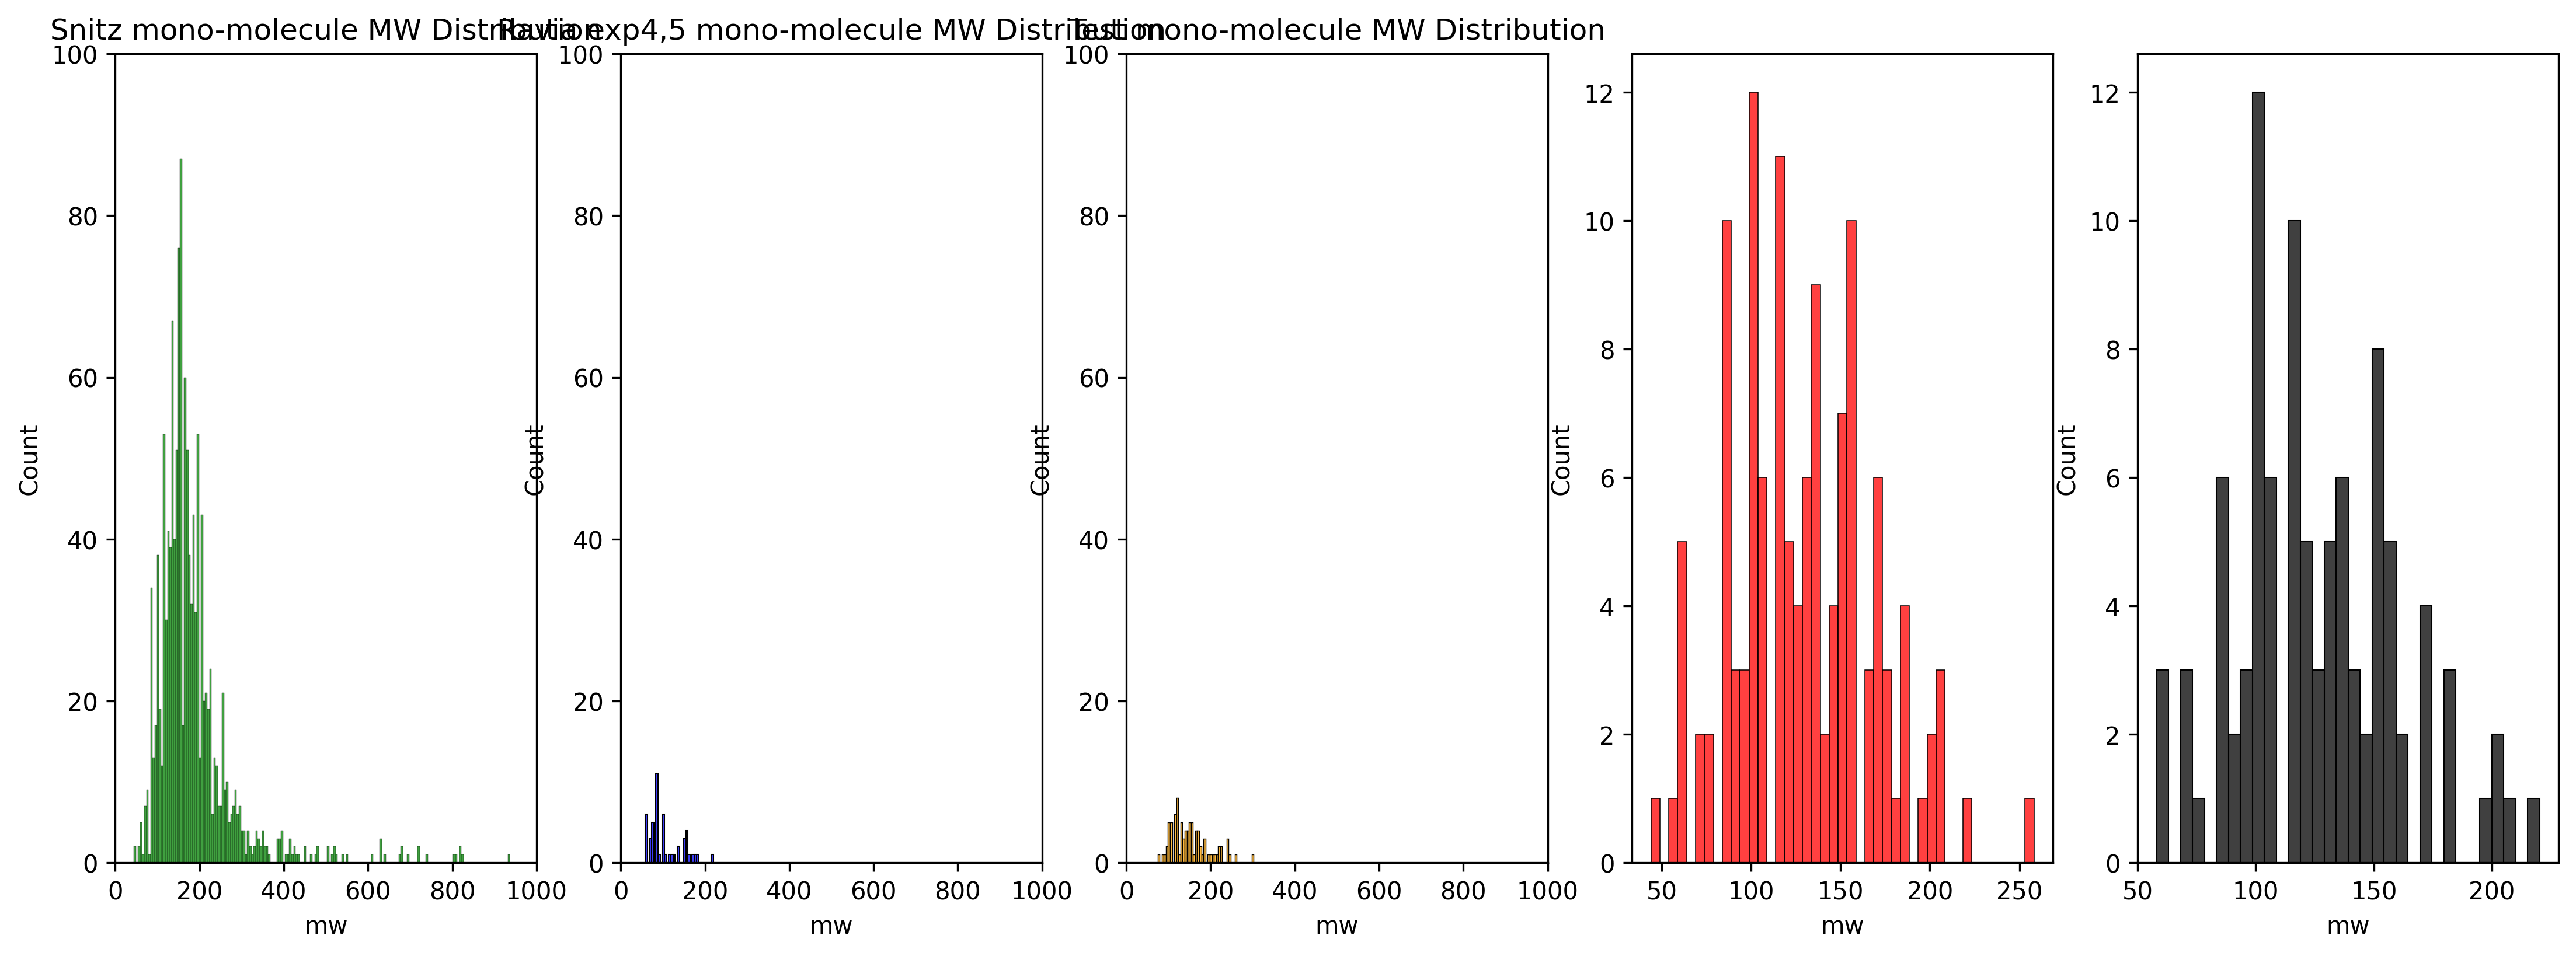

In [50]:
if True:
    fig, ax = plt.subplots(1, 5, figsize=(18, 6), dpi=300)
    g = sns.histplot(df_snitz["mw"], ax=ax[0], binwidth=5, color="green")
    ax[0].set_title("Snitz mono-molecule MW Distribution")
    ax[0].set_xlim([0, 1000])
    ax[0].set_ylim([0, 100])

    g = sns.histplot(df_ravia45["mw"], ax=ax[1], binwidth=5, color="b")
    ax[1].set_title("Ravia exp4,5 mono-molecule MW Distribution")
    ax[1].set_xlim([0, 1000])
    ax[1].set_ylim([0, 100])

    g = sns.histplot(df_ravia12["mw"], ax=ax[2], binwidth=5, color="orange")
    ax[2].set_title("Ravia exp1,2 mono-molecule MW Distribution")
    ax[2].set_xlim([0, 1000])
    ax[2].set_ylim([0, 100])

    g = sns.histplot(df_bushdid["mw"], ax=ax[3], binwidth=5, color="red")
    ax[2].set_title("Bushdid mono-molecule MW Distribution")
    ax[2].set_xlim([0, 1000])
    ax[2].set_ylim([0, 100])

    g = sns.histplot(df_test["mw"], ax=ax[4], binwidth=5, color="black")
    ax[2].set_title("Test mono-molecule MW Distribution")
    ax[2].set_xlim([0, 1000])
    ax[2].set_ylim([0, 100])

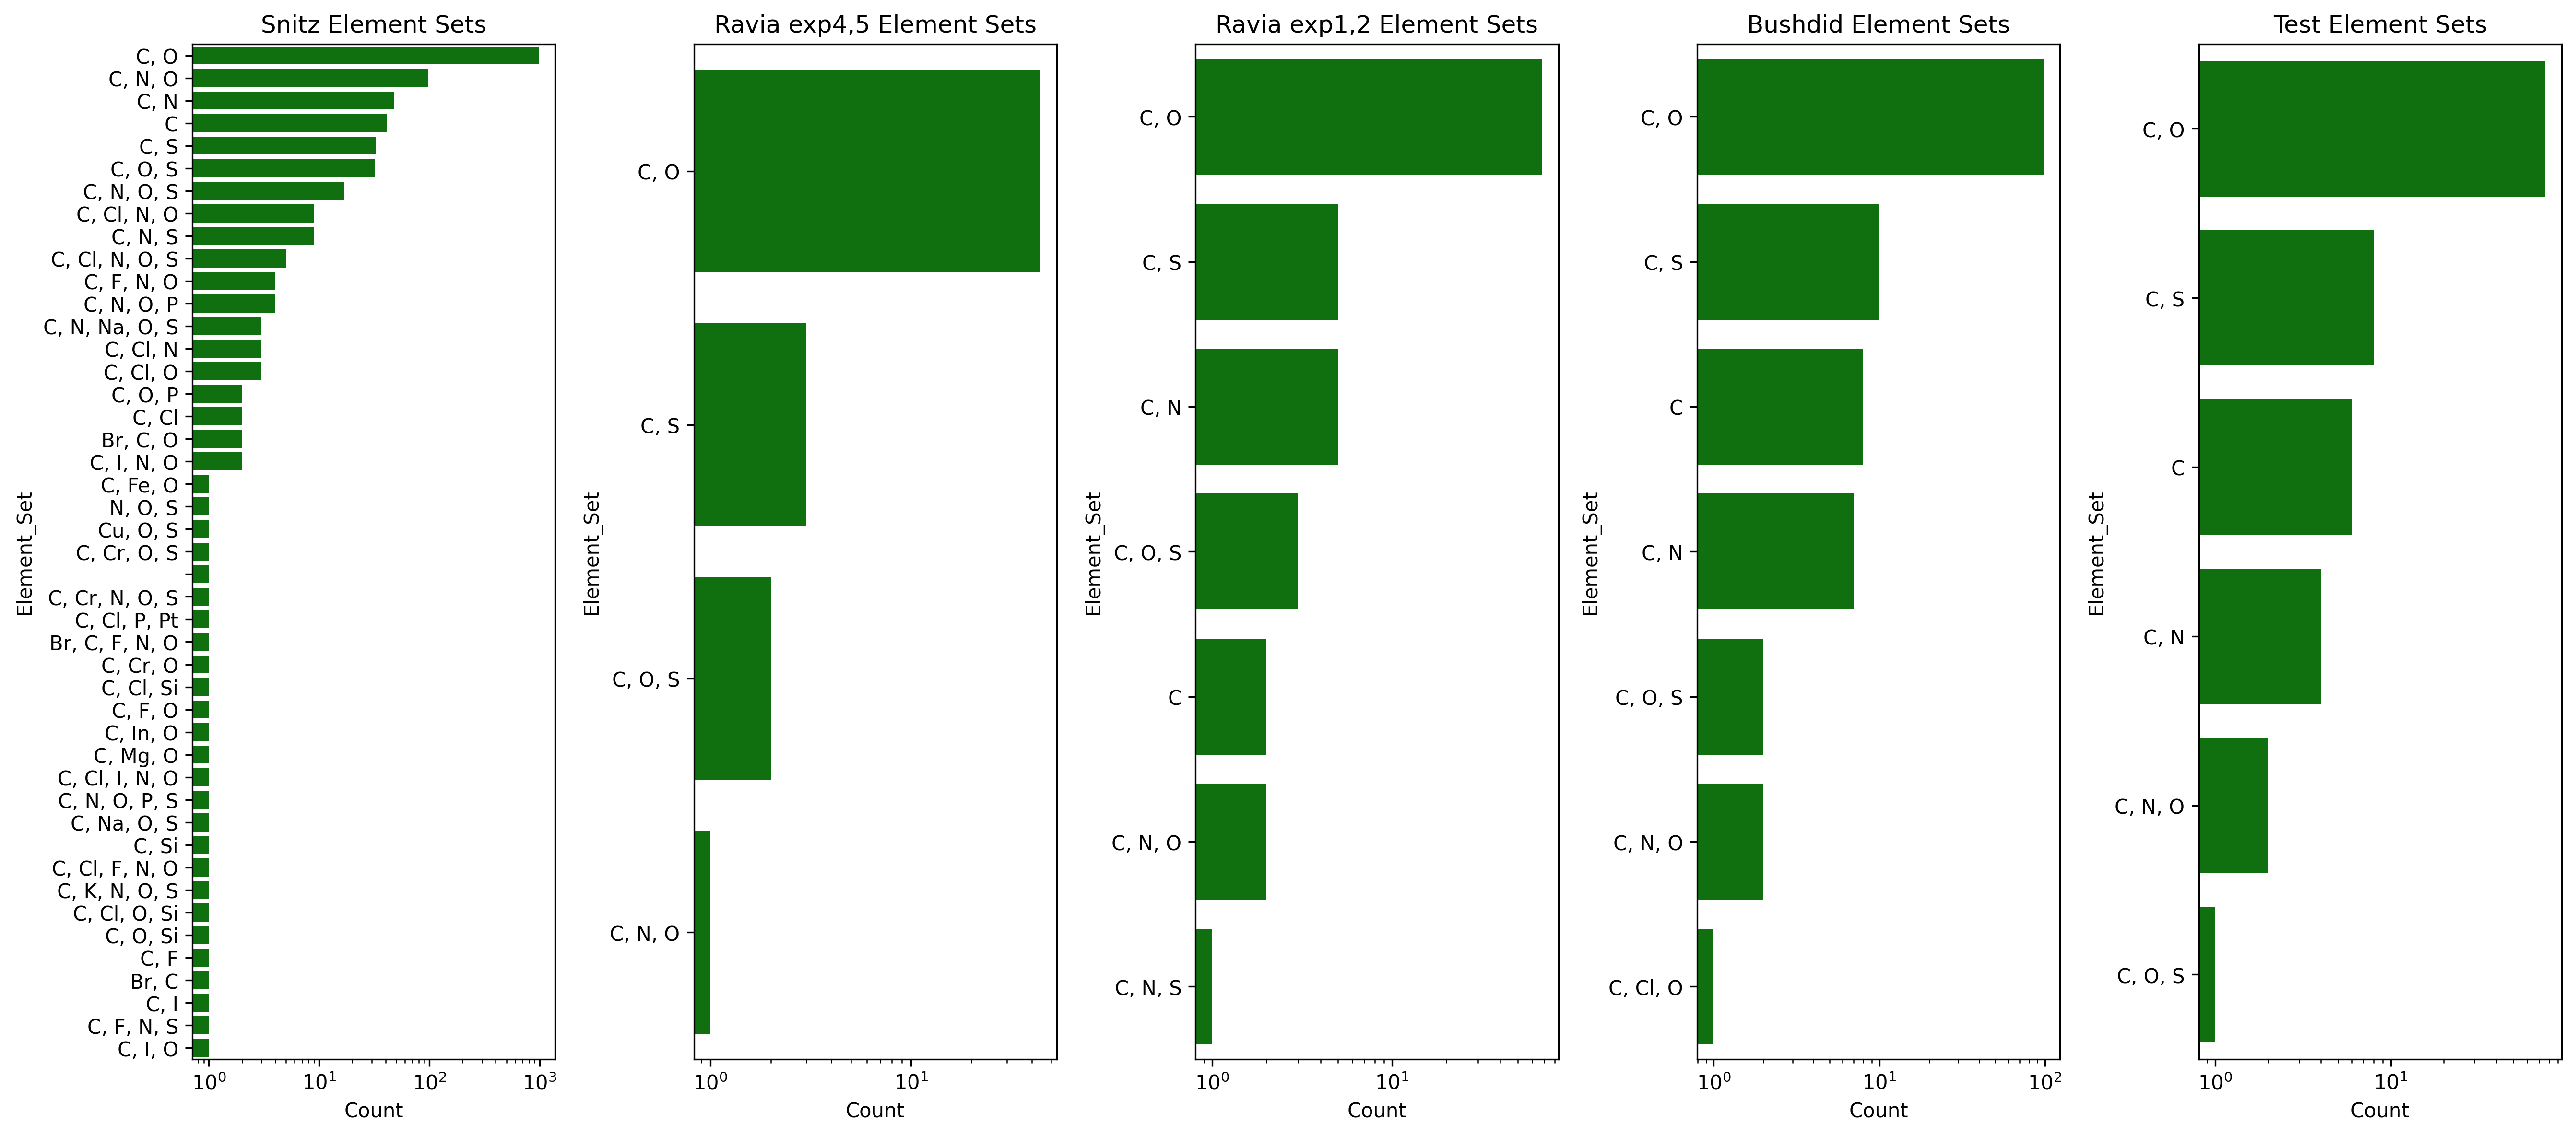

In [ ]:
df_snitz["Element_Sets"] = df_snitz["IsomericSMILES"].apply(
    lambda x: tuple(get_elements(x))
)
df_ravia45["Element_Sets"] = df_ravia45["IsomericSMILES"].apply(
    lambda x: tuple(get_elements(x))
)
df_ravia12["Element_Sets"] = df_ravia12["IsomericSMILES"].apply(
    lambda x: tuple(get_elements(x))
)
df_bushdid["Element_Sets"] = df_bushdid["IsomericSMILES"].apply(
    lambda x: tuple(get_elements(x))
)
df_test["Element_Sets"] = df_test["IsomericSMILES"].apply(
    lambda x: tuple(get_elements(x))
)

# Create a Counter to count the occurrences of each set of elements
element_set_counts_snitz = Counter(df_snitz["Element_Sets"])
element_set_counts_ravia45 = Counter(df_ravia45["Element_Sets"])
element_set_counts_ravia12 = Counter(df_ravia12["Element_Sets"])
element_set_counts_bushdid = Counter(df_bushdid["Element_Sets"])
element_set_counts_test = Counter(df_test["Element_Sets"])

element_set_counts_snitz_df = pd.DataFrame(
    list(element_set_counts_snitz.items()), columns=["Element_Set", "Count"]
)
element_set_counts_ravia45_df = pd.DataFrame(
    list(element_set_counts_ravia45.items()), columns=["Element_Set", "Count"]
)
element_set_counts_ravia12_df = pd.DataFrame(
    list(element_set_counts_ravia12.items()), columns=["Element_Set", "Count"]
)
element_set_counts_bushdid_df = pd.DataFrame(
    list(element_set_counts_bushdid.items()), columns=["Element_Set", "Count"]
)
element_set_counts_test_df = pd.DataFrame(
    list(element_set_counts_test.items()), columns=["Element_Set", "Count"]
)

# Convert tuple to string for better plotting
element_set_counts_snitz_df["Element_Set"] = element_set_counts_snitz_df[
    "Element_Set"
].apply(lambda x: ", ".join(x))
element_set_counts_ravia45_df["Element_Set"] = element_set_counts_ravia45_df[
    "Element_Set"
].apply(lambda x: ", ".join(x))
element_set_counts_ravia12_df["Element_Set"] = element_set_counts_ravia12_df[
    "Element_Set"
].apply(lambda x: ", ".join(x))
element_set_counts_bushdid_df["Element_Set"] = element_set_counts_bushdid_df[
    "Element_Set"
].apply(lambda x: ", ".join(x))
element_set_counts_test_df["Element_Set"] = element_set_counts_test_df[
    "Element_Set"
].apply(lambda x: ", ".join(x))

fig, ax = plt.subplots(1, 5, figsize=(18, 8), dpi=300)

sns.barplot(
    data=element_set_counts_snitz_df.sort_values("Count", ascending=False),
    y="Element_Set",
    x="Count",
    color="green",
    ax=ax[0],
    orient="h",
)
ax[0].set_xscale("log")
ax[0].set_title("Snitz Element Sets")

sns.barplot(
    data=element_set_counts_ravia45_df.sort_values("Count", ascending=False),
    y="Element_Set",
    x="Count",
    color="green",
    ax=ax[1],
    orient="h",
)
ax[1].set_xscale("log")
ax[1].set_title("Ravia exp4,5 Element Sets")

sns.barplot(
    data=element_set_counts_ravia12_df.sort_values("Count", ascending=False),
    y="Element_Set",
    x="Count",
    color="green",
    ax=ax[2],
    orient="h",
)
ax[2].set_xscale("log")
ax[2].set_title("Ravia exp1,2 Element Sets")

sns.barplot(
    data=element_set_counts_bushdid_df.sort_values("Count", ascending=False),
    y="Element_Set",
    x="Count",
    color="green",
    ax=ax[3],
    orient="h",
)
ax[3].set_xscale("log")
ax[3].set_title("Bushdid Element Sets")

sns.barplot(
    data=element_set_counts_test_df.sort_values("Count", ascending=False),
    y="Element_Set",
    x="Count",
    color="green",
    ax=ax[4],
    orient="h",
)
ax[4].set_xscale("log")
ax[4].set_title("Test Element Sets")

# Adjust layout for better readability
plt.tight_layout()
plt.show()